# ToDo: 
+ ~~期待値がほぼ 0 になっている理由を探す。回避できるようなら回避~~
+ ~~C = 3 * n_qubits の理由~~ (特に理由はない？)
+ ~~QPU のばらつき改善~~
+ 2 次のトロッターにしてみる
+ GHZ を中心に寄せる。このままだと不要な Trotter gate があるので。

## わかったこと
+ ハミルトニアンをシフトさせなければ成功
+ times = [2 * np.pi * k / C for k in range(n_features)] は失敗
+ times = [np.pi * k / C for k in range(n_features)] は成功

In [1]:
%matplotlib inline
%pip freeze > requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Add the fourier_learning_ibm package to the path
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']


In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os
from heisenberg_graph import (
    HeisenbergModel,
    get_n_steps,
    get_graph,
    get_positions,
    get_initial_layout,
    get_prob0,
    extract_probs,
)
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Batch
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
import mthree
import pickle
import networkx as nx
from datetime import datetime, timezone
import json
import math

In [5]:
n_qubits = 6

initial_state = np.zeros(2**n_qubits, dtype=complex)
initial_state[0] = 1
print(initial_state)

initial_state_2 = Statevector.from_label("0" * n_qubits)
print(initial_state_2.data)

print(np.allclose(initial_state, initial_state_2.data))

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
True


In [ ]:
# Option1: Use IBM Quantum backend.
# If you did not previously save your credentials, use the following line instead:

# !!!!!!!!!
# DANGER: Do not hardcode your token in your code. Use environment variables instead.
service = QiskitRuntimeService(
    channel="ibm_quantum",
    token="YOUR_IBM_QUANTUM_TOKEN",
)
# !!!!!!!!!

# service = QiskitRuntimeService()
# backend_qpu = service.least_busy(simulator=False, interactional=True)
backend_qpu = service.backend("ibm_marrakesh")

# Option2: Use local AerSimulator as the backend.
backend_sim = AerSimulator()

noise_model = NoiseModel.from_backend(backend_qpu)
backend_sim_noisy = AerSimulator(noise_model=noise_model)

print(f"Using backend QPU: {backend_qpu}")
print(f"Using backend simulator: {backend_sim}")
print(f"Using backend noisy simulator: {backend_sim_noisy}")

Using backend QPU: <IBMBackend('ibm_marrakesh')>
Using backend simulator: AerSimulator('aer_simulator')
Using backend noisy simulator: AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['measure', 'reset', 'id', 'cz', 'sx', 'x']>)


# データセット作成 $\exp(-\beta H)$

In [7]:
n_samples = 100
n_qubits = 6
beta = 1

graph_type = "line"
# ghz_qubits = list(range(n_qubits // 2))
# ghz_qubits = list(range(0, n_qubits, 2))
# print(f"GHZ qubits: {ghz_qubits}")

## Create graph (Demo)

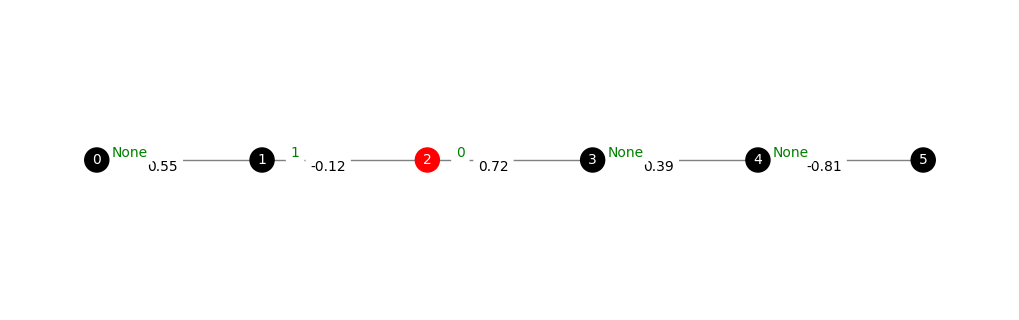

In [8]:
rng = np.random.default_rng(42)
G = get_graph(n_qubits, rng, graph_type)

positions = get_positions(n_qubits, graph_type)

# エッジラベルを作成
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
edge_cnot_order_labels = {edge: f"{G.edges[edge]['cnot']['order']}" for edge in G.edges}

# グラフを描画
plt.figure(figsize=(10, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["hadamard"] else "black" for node in G.nodes],
    node_size=300,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# エッジの重みを描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# エッジの 'cnot' 'order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_cnot_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.8,
    verticalalignment="bottom",
)

plt.show()

In [9]:
# State |111000> (half 1 and half 0 state) (can be adjusted for other sizes)
# index = "1" * (n_qubits // 2) + "0" * (n_qubits // 2)
# print(f"binary index: {index}")

# state = Statevector.from_label(index)
# print(f"index: {int(index, 2)}")
# print(state[int(index, 2)])

In [10]:
# State |0011...1100> (center qubits are 1 and the rest are 0)
leftmost = n_qubits // 4
rightmost = leftmost + n_qubits // 2 - 1
index = []
for i in range(n_qubits):
    if leftmost <= i <= rightmost:
        index.append("1")
    else:
        index.append("0")

index = "".join(index)
print(f"binary index: {index}")
state = Statevector.from_label(index)

print(f"decimal: {int(index, 2)}")
print(state[int(index, 2)])

binary index: 011100
decimal: 28
(1+0j)


## Non Trotter simulation (directly compute the expectation value)

In [11]:
hamiltonian = HeisenbergModel(n_qubits, G)
H = hamiltonian.H

In [12]:
H_dense = Operator(H).reverse_qargs().to_matrix()
U_dense = scipy.linalg.expm(-beta * H_dense)
H_sparse = Operator(H).reverse_qargs().to_matrix()
H_sparse = scipy.sparse.csc_matrix(H_sparse)
U_sparse = scipy.sparse.linalg.expm(-beta * H_sparse).toarray()

print(np.allclose(U_dense, U_sparse))

True


In [13]:
data = []
graphs = []
rng = np.random.default_rng(42)

for i in range(n_samples):
    print(f"Sample {i}/{n_samples}")
    G = get_graph(n_qubits, rng, graph_type)
    Js = [G.edges[edge]["J"] for edge in G.edges]
    heisenberg = HeisenbergModel(n_qubits, G)

    H = heisenberg.H
    # H = H.to_matrix(sparse=True)
    H = Operator(H).reverse_qargs().to_matrix()
    H = scipy.sparse.csr_matrix(H)

    fH = scipy.sparse.linalg.expm(-beta * H)
    # Compute the expectation value <state|exp(-beta*H)|state>
    y = np.vdot(state, fH @ state).real

    data.append({"Js": Js, "expected_value": y})
    graphs.append(G)

df = pd.DataFrame(data)
df

Sample 0/100
Sample 1/100
Sample 2/100
Sample 3/100
Sample 4/100
Sample 5/100
Sample 6/100


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Sample 7/100
Sample 8/100
Sample 9/100
Sample 10/100
Sample 11/100
Sample 12/100
Sample 13/100
Sample 14/100
Sample 15/100
Sample 16/100
Sample 17/100
Sample 18/100
Sample 19/100
Sample 20/100
Sample 21/100
Sample 22/100
Sample 23/100
Sample 24/100
Sample 25/100
Sample 26/100
Sample 27/100
Sample 28/100
Sample 29/100
Sample 30/100
Sample 31/100
Sample 32/100
Sample 33/100
Sample 34/100
Sample 35/100
Sample 36/100
Sample 37/100
Sample 38/100
Sample 39/100
Sample 40/100
Sample 41/100
Sample 42/100
Sample 43/100
Sample 44/100
Sample 45/100
Sample 46/100
Sample 47/100
Sample 48/100
Sample 49/100
Sample 50/100
Sample 51/100
Sample 52/100
Sample 53/100
Sample 54/100
Sample 55/100
Sample 56/100
Sample 57/100
Sample 58/100
Sample 59/100
Sample 60/100
Sample 61/100
Sample 62/100
Sample 63/100
Sample 64/100
Sample 65/100
Sample 66/100
Sample 67/100
Sample 68/100
Sample 69/100
Sample 70/100
Sample 71/100
Sample 72/100
Sample 73/100
Sample 74/100
Sample 75/100
Sample 76/100
Sample 77/100
Sample 78

,Js,expected_value
0,"[0.5479120971119267, -0.12224312049589536, 0.7...",7.391106
1,"[0.9512447032735118, 0.5222794039807059, 0.572...",7.380861
2,"[-0.25840395153483753, 0.8535299776972036, 0.2...",1.560675
3,"[-0.5455225564304462, 0.1091695740316696, -0.8...",5.663484
4,"[0.5161754801707477, -0.2909480637402633, 0.94...",16.957718
...,...,...
95,"[-0.3905907924783374, -0.14419357263730004, 0....",1.463780
96,"[-0.18243378114260578, -0.564742946606076, 0.1...",2.774891
97,"[-0.16319991168627923, -0.05173464981965936, -...",1.709296
98,"[0.40400436222074276, 0.2958969644024201, 0.30...",0.794244


## Pre-process data

In [14]:
df["expected_value"].describe()

count    100.000000
mean       7.831787
std       15.304763
min        0.238580
25%        1.503144
50%        3.079344
75%        7.383422
max      124.721404
Name: expected_value, dtype: float64

In [15]:
# Query the 80% quantile
q = df["expected_value"].quantile(0.8)
filtered_index = df.query(f"expected_value < @q").index
diffrence = df.index.difference(filtered_index)
print(f"Outliers: {diffrence}")

# Remove outliers
df = df.drop(diffrence).reset_index(drop=True)
graphs = [graph for i, graph in enumerate(graphs) if i not in diffrence]

Outliers: Index([4, 9, 20, 27, 30, 34, 37, 38, 43, 45, 58, 59, 66, 69, 72, 77, 78, 81,
       82, 86],
      dtype='int64')


In [16]:
display(df)

n_samples = len(df)
print(f"Number of samples: {n_samples}")
df["expected_value"].describe()

,Js,expected_value
0,"[0.5479120971119267, -0.12224312049589536, 0.7...",7.391106
1,"[0.9512447032735118, 0.5222794039807059, 0.572...",7.380861
2,"[-0.25840395153483753, 0.8535299776972036, 0.2...",1.560675
3,"[-0.5455225564304462, 0.1091695740316696, -0.8...",5.663484
4,"[-0.6107225842960649, -0.06655799254593164, -0...",1.889904
...,...,...
75,"[-0.3905907924783374, -0.14419357263730004, 0....",1.463780
76,"[-0.18243378114260578, -0.564742946606076, 0.1...",2.774891
77,"[-0.16319991168627923, -0.05173464981965936, -...",1.709296
78,"[0.40400436222074276, 0.2958969644024201, 0.30...",0.794244


Number of samples: 80


count    80.000000
mean      3.011704
std       2.358223
min       0.238580
25%       1.250583
50%       2.110908
75%       4.407075
max       9.245448
Name: expected_value, dtype: float64

## Check eigvals and Configure params

In [17]:
# Plot histogram of eigenvalues
# print(f"Number of samples: {n_samples}")
# eigvals_array = np.array(eigvals_list).flatten()
# plt.hist(eigvals_array, bins=50)
# plt.xlabel("Eigenvalues")
# plt.ylabel("Frequency")
# plt.title("Eigenvalues of Hamiltonian")
# plt.show()

In [18]:
n_features = 5  # Number of Fourier features

# Parameters for the Fourier feature generation
# For shifted Hamiltonian
# C = 20 * n_qubits  # upper bound for eigenvalues (WHY?)
# times = [2 * np.pi * k / C for k in range(n_features)]

# For unshifted Hamiltonian
C = 10 * n_qubits  # upper bound for eigenvalues
times = [np.pi * k / C for k in range(n_features)]

# C = max(matrix_norms)  # upper bound for eigenvalues
print(f"C: {C}")
# print(f"max matrix norm: {max(matrix_norms)}")  # For debugging
print(f"times: {times}")

C: 60
times: [0.0, 0.05235987755982988, 0.10471975511965977, 0.15707963267948966, 0.20943951023931953]


In [19]:
# Only for CP1
%cd fourier_learning_ibm/

/home/jovyan/fourier_learning_ibm


In [20]:
CURRENT_TIME = (
    datetime.now(timezone.utc).isoformat(timespec="minutes").replace("+00:00", "Z")
)

path = f"./data/{CURRENT_TIME}"
# path = f"./data/{current_time}/{n_qubits}_{backend_qpu.name}_{graph_type}"
os.makedirs(path, exist_ok=True)
print("Note: This CURRENT_TIME is used for other notebooks.")
print(f"CURRENT_TIME: {CURRENT_TIME}")
print(f"Saving data to {path}")

Note: This CURRENT_TIME is used for other notebooks.
CURRENT_TIME: 2024-12-01T06:22Z
Saving data to ./data/2024-12-01T06:22Z


In [21]:
# Save parameters

# Save the graphs as a binary file
with open(f"{path}/params_object.pkl", "wb") as f:
    pickle.dump(
        {
            "graphs": graphs,
            "Js": df["Js"].values,
            "expected_values": df["expected_value"].values,
        },
        f,
    )

# Save the parameters as a JSON file
with open(f"{path}/params_text.json", "w") as f:
    json.dump(
        {
            "n_samples": n_samples,
            "n_qubits": n_qubits,
            "graph_type": graph_type,
            "backend_qpu_name": backend_qpu.name,
            "beta": beta,
            "C": C,
            "n_features": n_features,
            "times": times,
        },
        f,
    )